In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional
from keras.optimizers import Adam

In [ ]:

df = pd.read_csv('/content/drive/My Drive/Sharer.pw/dataset_final.csv')
df.set_index(pd.to_datetime(df.date),inplace=True)
df.drop(['Unnamed: 0','date'],axis=1,inplace=True)
df.head()

#split the into train and test dataset
test_data = pd.concat([df['2020-02'],df['2020-03'],df['2020-04']],axis=0)
train_data = df[:-len(test_data)]

train_data.head()

,btc_price,gold_price,oil_wti_price,sp500_close,btc_num_trans,btc_google_search,btc_dr,gold_dr,oil_dr,sp500_dr,BVOL,GVOL,OVOL,VIX
date,,,,,,,,,,,,,,
2015-01-15,211.91,1352.8,46.37,1992.67,102309.0,3,0.568670,0.021141,-0.044705,-0.009291,0.853974,0.344132,0.344950,22.39
2015-01-16,199.46,1364.9,48.49,2019.42,104699.0,3,-0.060548,0.008905,0.044705,0.013335,0.857286,0.348453,0.346061,20.95
2015-01-20,208.00,1377.4,46.79,2022.55,98485.0,3,0.041924,0.009116,-0.035688,0.001549,0.857176,0.348518,0.346647,19.89
2015-01-21,225.51,1378.4,47.85,2032.12,98485.0,3,0.080826,0.000726,0.022402,0.004720,0.893605,0.350149,0.347336,18.85
2015-01-22,226.32,1390.2,45.93,2063.15,93698.0,3,0.003585,0.008524,-0.040953,0.015154,0.904949,0.351242,0.343230,16.40


In [ ]:
#selecting the daily returns form the dataset
train_data = train_data[['btc_dr','gold_dr','oil_dr','sp500_dr']]
X = train_data.values
scalar = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scalar.fit_transform(X)

In [ ]:
X_train = []
y_train = []

# Number of days we want top predict into the future
n_future = len(test_data)   
# Number of past days we want to use to predict the future
timesteps = 5    
for i in range(timesteps, len(X) - n_future +1):
    X_train.append(X[i - timesteps:i, 0:X.shape[1] - 1])
    y_train.append(X[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(f'X_train shape = {X_train.shape}.')
print(f'y_train shape = {y_train.shape}.')

X_train shape = (1201, 5, 3).
y_train shape = (1201, 1).


In [ ]:
#defining LSTM model
def lstm_model():
  model = Sequential()
  model.add(Bidirectional(LSTM(64,activation='relu'),input_shape=(X_train.shape[1],X_train.shape[2])))

  model.add(Dense(1))
  adam = Adam(learning_rate=0.0001, beta_1=10, beta_2=0.999, epsilon=1e-07)
  model.compile(optimizer='adam',loss='mae')
  return model

model = lstm_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 128)               34816     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 34,945
Trainable params: 34,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit the model
model.fit(X_train,y_train,epochs=100,shuffle=False)

Epoch 1/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0380
Epoch 2/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0380
Epoch 3/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0380
Epoch 4/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0379
Epoch 5/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0378
Epoch 6/100
38/38 [==============================] - 0s 7ms/step - loss: 0.0378
Epoch 7/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0378
Epoch 8/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0377
Epoch 9/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0377
Epoch 10/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0377
Epoch 11/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0376
Epoch 12/100
38/38 [==============================] - 0s 6ms/step - loss: 0.0377
Epoch 13/100
38/38 [=================

In [ ]:
#forecast bitcoin daily returns
pred = model.predict(X_train[-n_future:])
sc = preprocessing.MinMaxScaler(feature_range=(0,1))
sc.fit(train_data.btc_dr.values.reshape((-1,1)))
pred = sc.inverse_transform(pred)

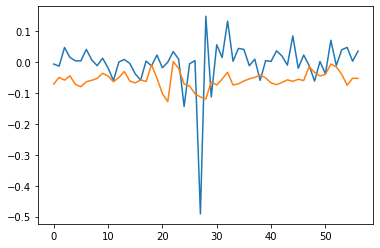

In [ ]:
#plotting the test values and predicted values
plt.figure()
plt.plot(test_data.btc_dr.values)
plt.plot(pred*10)